In [2]:
import numpy as np
import tensorflow as tf
import time
import h5py
# from Network.PatchHandler3D import PatchHandler3D
from Network.PatchHandler3D_temporal import PatchHandler4D
from test_iterator import check_compatibility, load_indexes
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from IPython.display import display
from utils.evaluate_utils import *
plt.rcParams['figure.figsize'] = [10, 8]

In [11]:
# show radial sampled data
dynamical_mask = '../data/CARDIAC/2mm_step2_static_dynamic.h5'
noisy_downsampled = '../data/CARDIAC/M1_2mm_step2_static_noise.h5'
data_1 = {}
data_2 = {}
vel_colnames = ['u', 'v','w']

with h5py.File(dynamical_mask, mode = 'r' ) as p1:
    with h5py.File(noisy_downsampled, mode = 'r' ) as p2:
            mask =  np.asarray(p1['mask'])
            temporal_mask = mask.copy()
            data_1['mask'] = temporal_mask
            data_2['mask'] = create_temporal_mask(np.asarray(p2['mask']).squeeze(), p2['u'].shape[0])
            # temporal_mask = create_temporal_mask(mask.squeeze(), p1['u'].shape[0])
            for vel in vel_colnames:
                data_1[vel] = np.asarray(p1[vel])
                data_2[vel] = np.asarray(p2[vel])

                data_1[f'{vel}_fluid'] = np.multiply(data_1[vel], temporal_mask)
                data_2[f'{vel}_fluid']  = np.multiply(data_2[vel] , temporal_mask)

           



Difference: 50279526.58484092


In [21]:
# print("Difference:", np.linalg.norm(data_2['mask']- data_1['mask']))
overlap_mask= np.zeros_like(data_1['u'])
overlap_mask[np.where(data_1['u'] != 0)] = 1
overlap_mask[np.where(data_1['v'] != 0)] = 1
overlap_mask[np.where(data_1['w'] != 0)] = 1


print(np.linalg.norm(overlap_mask - data_1['mask']))
print(np.count_nonzero(data_2['mask']- data_1['mask']))
print('Shape ', data_2['mask'].shape, 'total number of pixels: ', np.prod(data_2['mask'].shape), ' i.e.', np.prod(data_2['mask'].shape)/np.count_nonzero(data_2['mask']- data_1['mask']), ' %' )

0.0
588621
Shape  (50, 72, 70, 76) total number of pixels:  19152000  i.e. 32.537065446186936  %


In [14]:
@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(data_1['mask'][frame, x, :, :] )#vmin=min_v, vmax= max_v)
    plt.title('Dynamical Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(data_2['mask'][frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Static mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(data_1['mask'][frame, x, :, :] - data_2['mask'][frame, x, :, :])#vmin=min_v, vmax= max_v)
    plt.title('Difference')
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=5, description='frame', max=49), IntSlider(value=0, description='x', max…

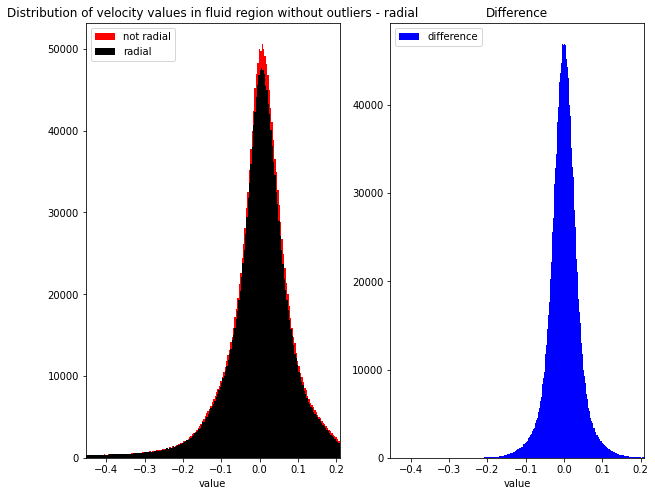

In [41]:
plt.subplot(1, 2, 1)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='red', label = 'not radial')   
plt.hist(p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'radial')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Distribution of velocity values in fluid region without outliers - radial")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(p2["u"][np.where(temporal_mask !=0)].flatten() - p1["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='blue', label = 'difference')  
plt.xlim(np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(p1["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
plt.xlabel('value')
plt.title("Difference")
plt.legend()

In [4]:
data_dir = '../data/CARDIAC'
    
# ---- Patch index files ----
training_file = '{}/Temporal14MODEL12_2mm_step2.csv'.format(data_dir)

# Hyperparameters optimisation variables
epochs =  1
batch_size =10

patch_size = 14
res_increase = 2


# Load data file and indexes
trainset = load_indexes(training_file)

# ----------------- TensorFlow stuff -------------------
# TRAIN dataset iterator
z = PatchHandler4D(data_dir, patch_size, res_increase, batch_size)
trainset = z.initialize_dataset(trainset, shuffle=False, n_parallel=2)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    start_time = time.time()
    for i, data_pairs in enumerate(trainset):
        start_loop = time.time()
        
        a = data_pairs
        #check if datapairs align
        lr_u, hr_u_mask, mask = check_compatibility(a)

        message = f"Iteration {i+1}   - batch {time.time()-start_loop:.4f} sec {time.time()-start_time:.1f} secs"
        print(f"\r{message}", end='')
        print(' ________________________')
        #break
        
print("\nDone")#


Total dataset: 1273 shuffle False

Epoch 1
Check compatibility of masks! Difference: 7246 / 27440 i.e.  26.4067055393586 %
LR u is not compatible with downsampled high res image!! 
Norm of difference:  0.5199413
Count nonzero 8582
Norm of difference:  0.5199413
LR v is not compatible with downsampled high res image!! 
Norm of difference:  0.4813361
LR w is not compatible with downsampled high res image!! 
Norm of difference:  0.49618322
Iteration 1   - batch 0.0068 sec 0.4 secs ________________________
Check compatibility of masks! Difference: 8559 / 27440 i.e.  31.191690962099127 %
LR u is not compatible with downsampled high res image!! 
Norm of difference:  0.5448159
Count nonzero 10500
Norm of difference:  0.5448159
LR v is not compatible with downsampled high res image!! 
Norm of difference:  0.50063235
LR w is not compatible with downsampled high res image!! 
Norm of difference:  0.51671207
Iteration 2   - batch 0.0043 sec 0.9 secs ________________________
Check compatibility of 

KeyboardInterrupt: 

In [3]:
p1 = mask
p2 = hr_u_mask
p3 = mask-hr_u_mask
print("shapes_", p1.shape, p2.shape, p3.shape)

min_v = -1#np.min(hr_u_downsampled)
max_v = 1#np.max(hr_u_downsampled)
#p3[np.where(p3 !=0)] = 1
overlap_masks = np.count_nonzero(p3)
print("Check compatibility of masks! Nonzero difference:", overlap_masks, '/', np.prod(list(hr_u_mask.shape)), 'i.e. ', 100*overlap_masks/np.prod(np.array(hr_u_mask.shape)) ,"%") 


@widgets.interact(frame=(0, p1.shape[0]-1), x = (0, p1.shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 3, 1)
    plt.imshow(p1[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title('Gt mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(p2[frame, x, :, :], vmin=min_v, vmax= max_v)
    plt.title("Non zero values for hr data")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(p3[frame, x, :, :], vmin=min_v, vmax= max_v, cmap='gray')
    plt.title("Difference")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

shapes_ (6, 14, 14, 14) (6, 14, 14, 14) (6, 14, 14, 14)
Check compatibility of masks! Nonzero difference: 3749 / 16464 i.e.  22.77089407191448 %


interactive(children=(IntSlider(value=5, description='frame', max=5), IntSlider(value=0, description='x', max=…